# Amazon Fine Food Reviews Analysis  - Truncated SVD


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


In this assignment I perform,

1. Data reading 
2. Exploratory Data Analysis 
3. Text Preprocessing on Review text data and Summary data 
4. Sample data from dataset and do time based splitting
5. Take 100k sample reviews and perform TF-IDF featurization on these
6. Obtain top 2000 words 
7. Co-occurance matrix
8. Truncated SVD
9. K-means and elbow method
10. Word Clouds for clusters
11. Function to get similar words for a given word using cosine similarity 




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [3]:

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
# Loading the data
# using SQLite Table to read data.
con = sqlite3.connect('I:\Python\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is necessary to remove duplicates in order to get unbiased results for the analysis of the data. Hence in order to reduce redundancy it's better to eliminate the rows that have same parameters.

The method used to perform deduplication is that, we first sort the data according to ProductId and then just keep the first similar product review and delete the others. This method ensures that there is only one representative for each product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis = 0, ascending = True, inplace = False, kind = 'quicksort', na_position = 'last')

#Dropping duplicates. It says that find duplicates with {'UserId', 'ProfileName', 'Time', 'Text'} values same. Then it is a duplicate
# By using drop_duplicate function we just keep the first product Id of the duplicates and remove the remaining.
final_data = sorted_data.drop_duplicates(subset = {'UserId', 'ProfileName', 'Time', 'Text'}, keep = 'first', inplace = False)

# Now it prints total reviews after removing duplicates.
print('Total number of reviews in the dataframe after removing duplicated:', final_data.shape)


Total number of reviews in the dataframe after removing duplicated: (364173, 10)


In [6]:
# HelpfulnessNumerator should always be less than HelpfulnessDenominator. 
# So check if any reviews have HelpfulnessNumerator greater than HelpfulnessDenominator and remove them

final_data = final_data[final_data.HelpfulnessNumerator <= final_data.HelpfulnessDenominator]
final_data.shape

(364171, 10)

In [7]:
#Checking to see how much % of data still remains
(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [8]:
# Lets see how many total reviews left
print(final_data.shape)

#How many positive and negative reviews are present in the dataset?
final_data['Score'].value_counts()


(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#### Observation:-

From the above output we can see that there are many positive reviews and fewer negative reviews.


#  [3] Text Preprocessing


Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis.

1. By removing stop-words, BoW vector will be small and more meaningful
2. Lemmatization is a process of breaking a sentence into words. It is language and context dependent

Hence in the Preprocessing phase we do the following in the order below:-

1. Remove all URL's
2. Remove all tags from the strings
3. Expanding English language contractions like, you've -> you have
4. Remove any punctuations or limited set of special characters like , or . or # etc.
5. Check if the word is made up of english letters and is not alpha-numeric
6. Remove words with numbers
7. Remove spacial characters
8. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
9. Convert the words to lowercase
10. Remove Stopwords
11. Finally Stemming the words which are related, to their stem form/root/base form (Snowball stemmer is used as it is obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

## [3.1].  Preprocessing Review Text


In [9]:
# printing some random reviews
sent_5 = final_data['Text'].values[5]
print(sent_5)
print("="*50)

sent_60000 = final_data['Text'].values[60000]
print(sent_60000)
print("="*50)

sent_15500 = final_data['Text'].values[15500]
print(sent_15500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.
<a href="http://www.amazon.com/gp/product/B000F4D5WG">Edward & Sons Organic Croutons, Italian Herbs, 5.25-Ounce Packs (Pack of 6)</a><br /><br />Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while.  Part of my diet consists of big salads and low fat Progresso soups. I wanted something extra that I could add to a salad  and/or a soup.  I decided to try these.  They are extremely salty and aside from that have no other taste.  I would not re order these again.  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming. Some foods are understan

In [10]:
# Remove urls from text ----  https://stackoverflow.com/a/40823105/4084039
import re
sent_5 = re.sub(r"http\S+", "", sent_5)
sent_60000 = re.sub(r"http\S+", "", sent_60000)
sent_15500 = re.sub(r"http\S+", "", sent_15500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_60000)

<a href=" & Sons Organic Croutons, Italian Herbs, 5.25-Ounce Packs (Pack of 6)</a><br /><br />Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while.  Part of my diet consists of big salads and low fat Progresso soups. I wanted something extra that I could add to a salad  and/or a soup.  I decided to try these.  They are extremely salty and aside from that have no other taste.  I would not re order these again.  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming. Some foods are understandably noted for being salty, anchovies, pretzels etc. I do eat pretzels and like them as long as I don't feel as if I put several tablespoons of salt in my mouth. I do not taste any of the herbs that I expected in a product which claims to have as one of it's ingredients Italian herbs.


In [11]:
# Removes all tags from a string --- https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_5, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_15500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.
I use this exclusively in all my cooking...I don't understand why the price went up so drastically...I have many of the ladies I work with that are hooked on this product and they want me to get them more
Can't do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.I use this as my SWEETENER in baking: cheesecakes, white brownies, muffin

In [12]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
sent_5 = decontracted(sent_5)
print(sent_5)
print("="*50)

A charming, rhyming book that describes the circumstances under which you eat (or do not) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they are out of recess and sing over and over until they drive the teachers crazy. It is cute and catchy and sounds really childlike but is skillfully written.


In [14]:
# Removes punctuations from strings ---  https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
sent_5 = re.sub(r"http\S+", "", sent_5)
sent_60000 = re.sub(r'[^\w\s]','', sent_60000)
sent_15500 = re.sub(r'[^\w\s]','', sent_15500)
sent_4900 = re.sub(r'[^\w\s]','', sent_4900)

print(sent_60000)

a href  Sons Organic Croutons Italian Herbs 525Ounce Packs Pack of 6abr br Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while  Part of my diet consists of big salads and low fat Progresso soups I wanted something extra that I could add to a salad  andor a soup  I decided to try these  They are extremely salty and aside from that have no other taste  I would not re order these again  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming Some foods are understandably noted for being salty anchovies pretzels etc I do eat pretzels and like them as long as I dont feel as if I put several tablespoons of salt in my mouth I do not taste any of the herbs that I expected in a product which claims to have as one of its ingredients Italian herbs


In [15]:
#remove words with numbers --- https://stackoverflow.com/a/18082370/4084039
sent_60000 = re.sub("\S*\d\S*", "", sent_60000).strip()
print(sent_60000)

a href  Sons Organic Croutons Italian Herbs  Packs Pack of  br Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while  Part of my diet consists of big salads and low fat Progresso soups I wanted something extra that I could add to a salad  andor a soup  I decided to try these  They are extremely salty and aside from that have no other taste  I would not re order these again  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming Some foods are understandably noted for being salty anchovies pretzels etc I do eat pretzels and like them as long as I dont feel as if I put several tablespoons of salt in my mouth I do not taste any of the herbs that I expected in a product which claims to have as one of its ingredients Italian herbs


In [16]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_4900 = re.sub('[^A-Za-z0-9]+', ' ', sent_4900)
print(sent_4900)

Cant do sugar Have tried scores of SF Syrups NONE of them can touch the excellence of this productbr br Thick delicious Perfect 3 ingredients Water Maltitol Natural Maple Flavor PERIOD No chemicals No garbagebr br Have numerous friends family members hooked on this stuff My husband son who do NOT like sugar free prefer this over major label regular syrupbr br I use this as my SWEETENER in baking cheesecakes white brownies muffins pumpkin pies etc Unbelievably deliciousbr br Can you tell I like it 


In [17]:
# Converting words into lowercase
sent_4900 = sent_4900.lower()
print(sent_4900)

cant do sugar have tried scores of sf syrups none of them can touch the excellence of this productbr br thick delicious perfect 3 ingredients water maltitol natural maple flavor period no chemicals no garbagebr br have numerous friends family members hooked on this stuff my husband son who do not like sugar free prefer this over major label regular syrupbr br i use this as my sweetener in baking cheesecakes white brownies muffins pumpkin pies etc unbelievably deliciousbr br can you tell i like it 


In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
# Combining all the above stundents 
#from tqdm import tqdm
final_strings = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in final_data['Text'].values:
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    final_strings.append(sentence.strip())

In [20]:
final_strings[55000]

'great product anyone would love even not gluten free great servicefast'

In [21]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [22]:
final_data['CleanedText'] = final_strings
final_data.shape
final_data.head(3)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...


In [23]:
print(final_data['Score'].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


## [3.2] Preprocessing Reviews Summary

In [24]:
# printing some random reviews
sent_6 = final_data['Text'].values[6]
print(sent_6)
print("="*50)

sent_5000 = final_data['Text'].values[5000]
print(sent_5000)
print("="*50)

sent_50000 = final_data['Text'].values[50000]
print(sent_50000)
print("="*50)

sent_355000 = final_data['Text'].values[355000]
print(sent_355000)
print("="*50)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had 

In [25]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_6, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_5000, 'lxml')
text= soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_50000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_355000, 'lxml')
text = soup.get_text()
print(text)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.First, this book taught him the months of the year.Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had Planters or regular "salted in the s

In [26]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [27]:
sent_5000 = decontracted(sent_5000)
print(sent_5000)
print("="*50)

late delivered, I paid extra charge for faster delivery but is not delivered on the time i have expected it.


In [28]:
#remove words with numbers ---- https://stackoverflow.com/a/18082370/4084039
sent_6 = re.sub("\S*\d\S*", "", sent_6).strip()
print(sent_6)

I set aside at least an hour each day to read to my son  y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to  y/o old to  /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [29]:
#remove spacial character ----- https://stackoverflow.com/a/5843547/4084039
sent_355000 = re.sub('[^A-Za-z0-9]+', ' ', sent_355000)
print(sent_355000)

Great taste and amazing crunch If you have never experienced the large deluxe fancy peanuts and have only had Planters or regular salted in the shell you are in for a wonderful experience The intense taste and solid crunch will keep your hand in the can til they are gone 


In [30]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
# Performing all the preprocessing steps on Summary data.
#from tqdm import tqdm
summary_data = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in final_data['Summary'].values:
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    summary_data.append(sentence.strip())

In [33]:
summary_data[56000]

'awesome yummy'

In [34]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [35]:
final_data['CleanedSummary'] = summary_data 
final_data.shape
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months


In [36]:
print(final_data['Score'].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


## 4. Sample the data from the Dataset

In [37]:
# Taking equal sample of negative and positive reviews each 50000, total 100,000 datapoints
positive_pts = final_data[final_data['Score'] == 1].sample(n=50000)
negative_pts = final_data[final_data['Score'] == 0].sample(n=50000)

# Concatenating both positive and negative points
total_score = pd.concat([positive_pts, negative_pts])
total_score.shape

(100000, 12)

### [4.1] Time Based Splitting

Generally we do random splitting of entire dataset into train, test, cross validate data. With this method we may not get correct accuracy everytime. With time products change and reviews for the product also change, hence with random splitting we may not get best value/accuracy.

But for Amazon Food Reviews Dataset Time based splitting is better than Random splittng. We can perform Time based splitting only when we have time feature in our dataset. Cross Validate data is used to find best hyper parameter and Test data is used to find accuracy and we train a model on all these.

So Time based splitting gives more accuracy than random splitting, even on the future data when data changes with time. It's preferable to do Time based splitting when time is available.

1. For each review in the dataset there is a timestamp. In Time based splitting, we first sort all the data in the dataset in increasing order(ascending) of time.
2. Now split 70% of data into Train data and remaining 30% of data into test data.



In [38]:
# sorting data using time
total_score['Time'] = pd.to_datetime(total_score['Time'])
total_score = total_score.sort_values(by = 'Time', ascending = True)


In [39]:
# display top 5 rows
total_score.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,1970-01-01 00:00:00.947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movie movie collection filled comedy actio...,great
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,1970-01-01 00:00:00.948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",always enjoyed movie funny entertaining not he...,warning clamshell edition edited tv version
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,1970-01-01 00:00:00.948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...,sure death flies
346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,1970-01-01 00:00:00.951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happens say name three times michael keaten st...,bettlejuicebettlejuicebettlejuice
346078,374383,B00004CI84,A34NBH479RB0E,"""dmab6395""",0,1,1,1970-01-01 00:00:00.977184000,FUNNY,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA...",thought movie funny michael keaton beetlejuice...,funny


# Truncated SVD

There are 2 types of Recommender systems (RS) 
1. Content based RS
2. Collaborative Filtering RS

Collaborative Filtering RS depends on the similar users who likes same items in the past, are more likely to like them in future also. It uses user rating information.

Content based RS is very similar to classification and regression techniques. It doesnot use user rating information of users on certain products to represent Yi. It uses other meta information like user age, gender, likes, place etc.

##### Similarity based RS algorithms:
there are 2 types
1. item-item based similarity
2. user-user similarity

###### user-user similarity:-
1. Build a user vector based on ratings
2. To compute a similarity matrix
3. Find most similar users
4. Find the items that are liked by these similar users
5. Recommend them

But a problem with user-user similarity is, the users preferences changes over time. So alternative approach is 

###### item-item similarity:
1. Here we represent each item as a vector.
2. In this case, ratings on a given item donot change significantly over time after initial peroid. Its bettwe to use item-item based similarity system in this case and when we have more users thsn items.

##### Matrix Factorization:- (MF)
1. When a matrix A which is mostly empty is decomposed into product of 2 or more other matrices with Multiplicative matrix decomposition and get a new matrix A^ which is fully filled and non empty and which is very close to original matrix A ,then this process is called Matrix Factorization. 
2. Now we can easily predict the rating for any user and item pair. 
3. Matrix A contains actual ratings, A^ contains predicted ratings predicted by MF model.So a MF model says, given a matrix A we break it into product of 2 matrices and do collaborative filtering where we use ratings already given by previous users to find new matrices B and C and we get a new matrix A^ where A^ = B * C Transpose. 
4. So we are trying to predict the values by using the existed values by solving optimization problem.  So we have predicted ratings that a user will give on any item.

PCA is an example of matrix factorization. PCA can be written in the form of Matrix Factorization. PCA is used for dimensionality reduction. PCA ia also called as eigen decomposition of a covariance matrix.

###### Singular Value Decomposition (SVD):-
It is a MF technique that is related to PCA. PCA is performed only of a covariance matrix which is a square, symmetric. SVD can be performed on any rectangular matrix.

1. K-means = MF + Column constraint on Z + 0-1 constraint on Z

2. 'd' is the hyperparameter in Truncated SVD. To determine d it is problem specific. Another systematic way to find best d is we can draw a plot with d on x-axis and error on y-axis.

3. As we increase d, the error starts to fall down, and after certain point it starts falling slowly than before. The error of drop is low and it is reducing slowly at certain point. 

4. Such point is called inflection point in optimization. So we consider the inflection point d as best hyperparameter as it is good tradeoff

###### Cold start problem:-
It occurs ehen we have a new user or item and we don't have ratings. One way to solve them is by using top items based on content-based Recommended systems.

##### Word vectors as MF:-
There are lots of word vectors that existed prior to word2vec like LSA,PLSA,LDA, GLOVE which is Global vectors which is related to w2v. 
###### Co-occurance matrix (X):-
1. Using the text corpus or text documents we compute a matrix where each cell in matrix is, number of times Wj occurs in the context of Wi across all the documents. Wj and Wi are in the neighbourhood of distance 5. Wj is in the neighbourhood of distance 5 to Wi. This is hw we build co-occurance matrix, and it is n cross n matrix where n is the number of words in dictionary.
2. Perform SVD where matrix X is decomposed into 3 other matrices U, sigma is a diagonal matrix, V_transpose which are all n cross n matrices.
##### Truncated SVD- 
1. Instead of keeping all columns in a matrix U, it discards some columns at the right most end and only keep K columns where K<n. So now matrix U is n cross k matrix.
2. In the same way matrix sigma is K cross K matrix where n-k columns and rows are discarded in this.
3. Matrix V_transpose becomes K cross n as only n-k rows are discarded in this case. At last we multiply 3 matrices U^, sigma^, V_transpose^ and we get a new matrix X^ which is a nice approximation to X
4. This process is similar to PCA . In this TruncatedSVD we take top K singular values and corresponding top K left singular and top K right singular vectors. 
5. The values which we discarded are smallest singular values which have least information and we just took top values which are important. 
6. 'K' is the hyperparameter in Truncated SVD. We have to give it as input along with the data matrix X
7. Now U^ rows contains U1,U2,....Un which are word vectors corresponding to W1, w2,...W2. Ui belongs to K as it is k-dimensional representation.
8. This process is co-occurance matrix + Truncated SVD
9. But problem with this process is, when the data is large and very large number of words then computing Truncated SVD is very expensive. 
9.So one solution to this problem is, instead of using all n words, we generally use top/most important n-words which are defined using TFIDF. If the TFIDF is high then the word is important. m<<n. 
10. So co-occurance matrix is build on this subset of most important words derived using TFIDF.


1. Eigen faces was one of the early techniques for face recognition. Today we don't use it anymore. We use Convolutional Neural Networks (CNN)


# [5] Featurization

## [5.1] TF-IDF

In [40]:
X = total_score['CleanedText'].values
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), use_idf = True) 
tfidf_data = tf_idf_vect.fit_transform(X)
print("the type of TFIDF vectorizer ",type(tfidf_data))
print(tfidf_data.get_shape())
print("the number of unique words ", tfidf_data.get_shape()[1])
    

the type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(100000, 1793635)
the number of unique words  1793635


In [41]:
# get_feature_names() function is used to get feature names and all are stored in a variable called 'features'
features = tf_idf_vect.get_feature_names()
len(features)

1793635

### [5.2]  Finding top 2000 features

In [42]:
def top_tfidf_feats(tfidf_data, features, top_n=2000):
    tfidf_mean = np.mean(tfidf_data, axis = 0)
    tfidf_mean = np.array(tfidf_mean)[0].tolist()
    topn_indices = np.argsort(tfidf_mean)[::-1][:top_n] 
    top_features = [(features[i], tfidf_mean[i])for i in topn_indices]
    df = pd.DataFrame(top_features)
    df.columns = ['feature', 'tfidf']
    return df
top_tfidf = top_tfidf_feats(tfidf_data, features, top_n=2000)

In [43]:
# printing top 2000 words with their tfidf score
top_tfidf

,feature,tfidf
0,not,0.024168
1,like,0.012935
2,product,0.010943
3,taste,0.010770
4,coffee,0.010538
5,good,0.010402
6,would,0.009665
7,tea,0.009324
8,one,0.009264
9,great,0.009014


In [44]:
# converting top 2000 words from dataframe to array
tfidf_2000 = top_tfidf['feature'].values
tfidf_2000

array(['not', 'like', 'product', ..., 'oven', 'ruined', 'classic'],
      dtype=object)

In [45]:
# converting top 2000 words to list
top_words = top_tfidf['feature'].values.tolist()
top_words

['not',
 'like',
 'product',
 'taste',
 'coffee',
 'good',
 'would',
 'tea',
 'one',
 'great',
 'flavor',
 'love',
 'no',
 'get',
 'really',
 'buy',
 'food',
 'amazon',
 'much',
 'price',
 'even',
 'tried',
 'use',
 'time',
 'chocolate',
 'find',
 'better',
 'little',
 'best',
 'bought',
 'also',
 'could',
 'make',
 'eat',
 'try',
 'box',
 'order',
 'well',
 'dog',
 'sugar',
 'tastes',
 'first',
 'bag',
 'water',
 'used',
 'made',
 'found',
 'way',
 'sweet',
 'got',
 'store',
 'drink',
 'ordered',
 'bad',
 'never',
 'two',
 'recommend',
 'know',
 'think',
 'stuff',
 'mix',
 'cup',
 'something',
 'go',
 'ever',
 'still',
 'brand',
 'thought',
 'since',
 'hot',
 'delicious',
 'give',
 'want',
 'tasted',
 'many',
 'money',
 'nice',
 'back',
 'free',
 'disappointed',
 'quality',
 'buying',
 'received',
 'hard',
 'flavors',
 'day',
 'say',
 'old',
 'products',
 'favorite',
 'different',
 'milk',
 'years',
 'item',
 'would not',
 'bit',
 'purchased',
 'package',
 'lot',
 'sure',
 'every',
 '

### [5.3]  Compute Co-Occurance matrix

In [50]:
# reference -- https://gist.github.com/nkt1546789/e9fc84579b9c8356f1e5
# https://stackoverflow.com/questions/41661801/python-calculate-the-co-occurrence-matrix

co_matrix = np.zeros((2000,2000))  # initializing co-occurance matrix of 2000*2000
def co_occurance_matrix(words,co_matrix):
    row = []
    column = []
    window_size = 5   # window_size is number of neighbours between the words is taken as 5
    for row in X:      # for each row in cleaned text data which is in X
        words = row.split()  # splitting/ breaking the row into words
        for index,word in enumerate(words):  # enumerate adds a counter with index and its corresponding word from the list of words
            if word in top_words:    # checks whether the word is in top_tfidf / top_2000 words 
                m = max(index-window_size, 0)
                n = min(index+window_size+1, len(words))
                for index2 in range(m,n):
                    if index2 == index:
                        continue
                    if words[index2] in top_words:       # top_words are top 2000 words
                        row = top_words.index(word)
                        column = top_words.index(words[index2])
                        co_matrix[row,column] += 1 
co_occurance_matrix(words,co_matrix)     
print(co_matrix)

[[3.1222e+04 1.9404e+04 1.0638e+04 ... 6.7000e+01 9.7000e+01 7.5000e+01]
 [1.9404e+04 6.5620e+03 2.4960e+03 ... 2.9000e+01 2.9000e+01 3.9000e+01]
 [1.0638e+04 2.4960e+03 2.6020e+03 ... 1.2000e+01 4.2000e+01 1.7000e+01]
 ...
 [6.7000e+01 2.9000e+01 1.2000e+01 ... 2.2000e+01 0.0000e+00 0.0000e+00]
 [9.7000e+01 2.9000e+01 4.2000e+01 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [7.5000e+01 3.9000e+01 1.7000e+01 ... 0.0000e+00 1.0000e+00 1.0000e+01]]


### [5.4]  Truncated SVD 

[0.86016305 0.88138933 0.900349   ... 1.         1.         1.        ]


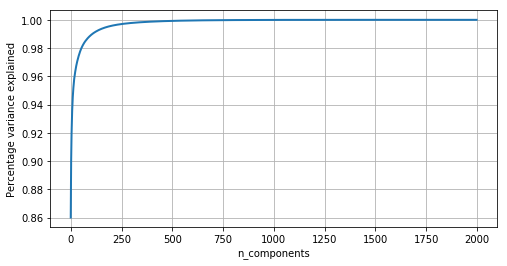

In [51]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = co_matrix.shape[1]-1)
svd_top_tfidf = svd.fit_transform(co_matrix)

percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_); # variance explained by each components

cum_var_explained = np.cumsum(percentage_var_explained)  # cumulative sum

print(cum_var_explained)

# plot the figure
plt.figure(1, figsize=(8, 4))

plt.clf()
plt.plot(cum_var_explained , linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Percentage variance explained')
plt.show()

#### Observation:- 
From this plot I took 300 components with maximum percentage variance explained.

### [5.5]  Finding optimal value for number of components (n) to be retained.

In [52]:
# from above plot, got n_components value as 300 and re-training the co-occurance matrix with this optimal components
svd = TruncatedSVD(n_components = 300)
svd_optimal = svd.fit_transform(co_matrix)


### [5.6]  Applying K-means clustering

In [53]:
from sklearn.cluster import KMeans

sum_of_intracluster_dist = []
K = [2,3,4,5,6,7,8,9,10]

for i in K:
    kmeans = KMeans(n_clusters = i, n_jobs = -1)
    kmeans.fit(svd_optimal)
    sum_of_intracluster_dist.append(kmeans.inertia_)
    

### [5.7]  Elbow method to find optimal number of clusters

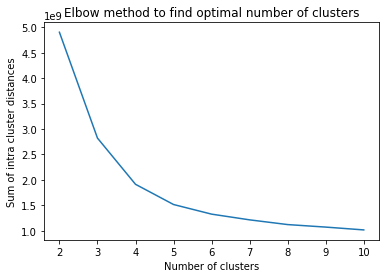

In [65]:
# Plotting between K and sum_of_intracluster_distances which is inertia
plt.plot(K, sum_of_intracluster_dist)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of intra cluster distances')
plt.title('Elbow method to find optimal number of clusters')
plt.show()

#### Observation:-

From the above plot with elbow method, I took optimal K = 3 , as the graph after 3 decreases gradually


### [5.8]  Retrain the model on optimal k 

In [54]:
optimal_k = KMeans(n_clusters = 3, n_jobs = -1)
km = optimal_k.fit(svd_optimal)

In [59]:
km.labels_

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [60]:
km.cluster_centers_

array([[ 5.09389962e+02, -3.56130013e+01, -3.70854704e+01,
         3.59011073e+01,  2.28920593e+00,  3.08996859e+01,
         3.72553645e+00, -5.13196358e+00, -1.14596175e+01,
         3.66714460e-01,  8.32341658e-01,  1.50108703e+00,
        -9.73941982e-01, -3.64631691e+00,  1.50276424e+00,
         2.42966903e+00, -8.33178616e-01,  6.03043221e+00,
        -1.70862969e+00, -4.63904054e+00, -4.57785332e+00,
        -3.07438141e+00, -1.35876754e-01, -2.71306857e+00,
         2.06747205e+00,  8.20145729e-01, -1.25797771e+00,
        -6.83817569e-01, -3.68799302e-01, -6.06624287e-01,
        -1.55271444e+00,  1.18189273e+00,  2.28212212e+00,
        -1.11774588e+00, -4.64157430e+00,  2.70950396e+00,
         2.05434889e+00, -6.04982492e-01, -3.58694599e+00,
         1.25948519e+00,  6.38954203e-02,  3.15467266e-02,
         1.74486594e+00, -1.89728764e+00, -1.81761103e+00,
         1.52962353e-02,  2.42315916e-01,  1.05790725e-01,
        -1.86321519e+00, -3.77700165e-01, -2.91785932e+0

### [5.9]  Word clusters

In [61]:
# Finding number of words in each cluster
cluster_data = top_words
C1 = []
C2 = []
C3 = []

for i in range(km.labels_.shape[0]):
    if km.labels_[i] == 0:
        C1.append(cluster_data[i])
    elif km.labels_[i] == 1:
        C2.append(cluster_data[i])
    else:
        C3.append(cluster_data[i])
                
print("Number of words in Cluster 1 : ",len(C1))
print("Number of words in Cluster 2 : ",len(C2))
print("Number of words in Cluster 3 : ",len(C3))


Number of words in Cluster 1 :  1957
Number of words in Cluster 2 :  1
Number of words in Cluster 3 :  42


### [5.10]  Printing words in each cluster

In [62]:
# reference - https://stackoverflow.com/questions/17788431/scikit-learn-how-to-know-documents-in-the-cluster?rq=1
# Printing words for cluster 1

k=1
for i in range(100):   # printing only 100 words from 1957 words to check
    print('word - %d: \n %s\n'%(k, C1[i]))
    k +=1


word - 1: 
 best

word - 2: 
 bought

word - 3: 
 box

word - 4: 
 order

word - 5: 
 dog

word - 6: 
 bag

word - 7: 
 water

word - 8: 
 used

word - 9: 
 made

word - 10: 
 found

word - 11: 
 way

word - 12: 
 got

word - 13: 
 store

word - 14: 
 ordered

word - 15: 
 never

word - 16: 
 two

word - 17: 
 recommend

word - 18: 
 stuff

word - 19: 
 mix

word - 20: 
 cup

word - 21: 
 something

word - 22: 
 go

word - 23: 
 ever

word - 24: 
 still

word - 25: 
 brand

word - 26: 
 thought

word - 27: 
 since

word - 28: 
 hot

word - 29: 
 delicious

word - 30: 
 give

word - 31: 
 want

word - 32: 
 tasted

word - 33: 
 many

word - 34: 
 money

word - 35: 
 nice

word - 36: 
 back

word - 37: 
 free

word - 38: 
 disappointed

word - 39: 
 quality

word - 40: 
 buying

word - 41: 
 received

word - 42: 
 hard

word - 43: 
 flavors

word - 44: 
 day

word - 45: 
 say

word - 46: 
 old

word - 47: 
 products

word - 48: 
 favorite

word - 49: 
 different

word - 50: 
 milk

word 

In [64]:
# words in cluster 2. there is only 1 word in cluster 2
for i in range(1):
    print('word - %d: \n %s\n'%(k, C2[i]))
    k +=1

word - 102: 
 not



In [65]:
# words in cluster 3
for i in range(42):
    print('word - %d: \n %s\n'%(k, C3[i]))
    k +=1

word - 103: 
 like

word - 104: 
 product

word - 105: 
 taste

word - 106: 
 coffee

word - 107: 
 good

word - 108: 
 would

word - 109: 
 tea

word - 110: 
 one

word - 111: 
 great

word - 112: 
 flavor

word - 113: 
 love

word - 114: 
 no

word - 115: 
 get

word - 116: 
 really

word - 117: 
 buy

word - 118: 
 food

word - 119: 
 amazon

word - 120: 
 much

word - 121: 
 price

word - 122: 
 even

word - 123: 
 tried

word - 124: 
 use

word - 125: 
 time

word - 126: 
 chocolate

word - 127: 
 find

word - 128: 
 better

word - 129: 
 little

word - 130: 
 also

word - 131: 
 could

word - 132: 
 make

word - 133: 
 eat

word - 134: 
 try

word - 135: 
 well

word - 136: 
 sugar

word - 137: 
 tastes

word - 138: 
 first

word - 139: 
 sweet

word - 140: 
 drink

word - 141: 
 bad

word - 142: 
 know

word - 143: 
 think

word - 144: 
 sure



## [5.11]  Word Clouds

### [5.12]  Word cloud for cluster 1

Word Cloud for Cluster 1


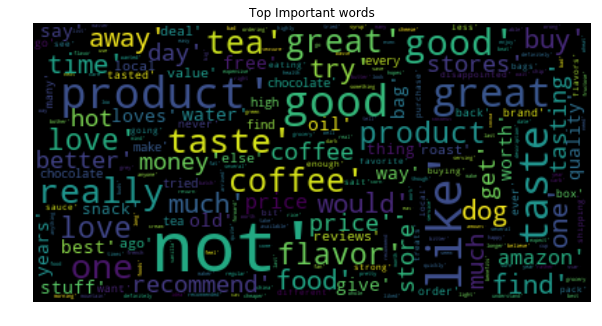

In [71]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 
stopwords_t = set(STOPWORDS)

wordcloud = WordCloud(background_color="black", max_words=len(str(C1)), stopwords=stopwords_t, max_font_size=50)
wordcloud.generate(str(C1))
print("Word Cloud for Cluster 1")
plt.figure(figsize=(10,10))
plt.title("Top Important words")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.13] Word cloud for cluster 2

Word Cloud for Cluster 2


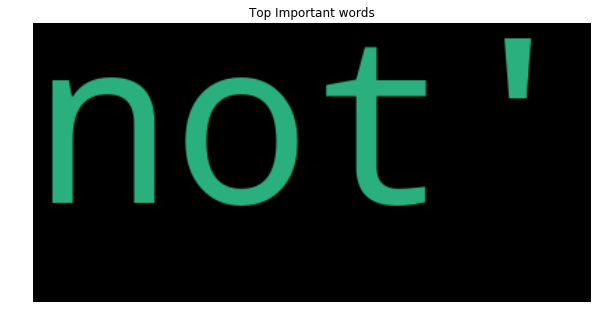

In [74]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 
stopwords_t = set(STOPWORDS)

wordcloud = WordCloud(background_color="black", max_words=len(str(C2)), stopwords=stopwords_t)
wordcloud.generate(str(C2))
print("Word Cloud for Cluster 2")
plt.figure(figsize=(10,10))
plt.title("Top Important words")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.14]  Word cloud for cluster 3

Word Cloud for Cluster 3


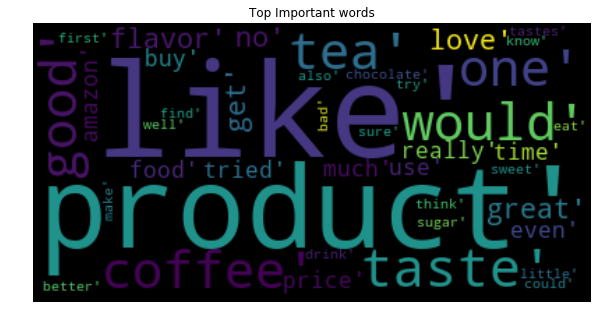

In [75]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 
stopwords_t = set(STOPWORDS)

wordcloud = WordCloud(background_color="black", max_words=len(str(C3)), stopwords=stopwords_t)
wordcloud.generate(str(C3))
print("Word Cloud for Cluster 3")
plt.figure(figsize=(10,10))
plt.title("Top Important words")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.15]  Function to return the most similar words for a given word using cosine similarity between the vectors

In [120]:
# reference - https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity/18914884
from sklearn.metrics.pairwise import cosine_similarity
# Printing top 20 similar words
# finding cosine similarity of words
cosine_sim = cosine_similarity(co_matrix)
# stacking top words to the cosine similarity which we got from co-occurance matrix and storing in words
sim_words = cosine_sim[top_words.index(word)]   
print("Words which are similar to", word,"\n")
index = sim_words.argsort()[::-1][1:21]  # sorting top 20 words
for i in range(len(index)):
    print((i+1),"word", top_words[index[i]],"is similar to",word,"\n")


Words which are similar to beef 

1 word jerky is similar to beef 

2 word turkey is similar to beef 

3 word chicken is similar to beef 

4 word pork is similar to beef 

5 word meat is similar to beef 

6 word broth is similar to beef 

7 word gravy is similar to beef 

8 word fish is similar to beef 

9 word soup is similar to beef 

10 word also is similar to beef 

11 word cooked is similar to beef 

12 word tough is similar to beef 

13 word vegetables is similar to beef 

14 word seasoning is similar to beef 

15 word salmon is similar to beef 

16 word vegetarian is similar to beef 

17 word etc is similar to beef 

18 word mostly is similar to beef 

19 word course is similar to beef 

20 word type is similar to beef 



## 6. Conclusions

From all the above observations,

1. After TFIDF featurization, I took top 2000 words and obtained co-occurance matrix.
2. Applied Truncated SVD on this and found 300 components with maximum variance explained.   n_components = 300
3. Then re-trained the co-occurance matrix with optimal 300 components and applied K-means on this.
4. Found optimal number of clusters using elbow method. optimal clusters(k) = 3 . Re-trained the model on optimal k
5. Created word clouds for each cluster with all the words in it.
6. Through cosine similarity, I found top 20 most similar words for the a particular word- beef. All the words are predicted correctly which are very similar to word beef.